# 4.1 強化学習におけるオフ方策評価
参考文献
- Nan Jiang and Lihong Li. [Doubly Robust Off-policy Value Evaluation for Reinforcement Learning](https://arxiv.org/abs/1511.03722). ICML2016.
- Philip S. Thomas and Emma Brunskill. [Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning](https://arxiv.org/abs/1604.00923). ICML2016.
- Nathan Kallus and Masatoshi Uehara. [Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning](https://arxiv.org/abs/1906.03735). NeurIPS2019.
- Tengyang Xie, Yifei Ma, and Yu-Xiang Wang. [Towards Optimal Off-Policy Evaluation for Reinforcement Learning with Marginalized Importance Sampling](https://arxiv.org/abs/1906.03393). NeurIPS2019.

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

from dataset import generate_synthetic_data, calc_true_value
from estimators import calc_avg, calc_tis, calc_sis, calc_dr, calc_mis
from utils import softmax, eps_greedy_policy, aggregate_simulation_results

### ログデータのサイズ$n$を変化させたときの各種推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [2]:
## シミュレーション設定
num_runs = 500 # シミュレーションの繰り返し回数
dim_state = 5 # 状態sの次元
num_states = 50 # 状態数, |S|
num_actions = 10 # 行動数, |A|
H = 6 # 軌跡の長さ
beta = -3 # データ収集方策のパラメータ
random_state = 12345
random_ = check_random_state(random_state)
num_data_list = [250, 500, 1000, 2000, 4000] # ログデータのサイズ

In [3]:
## 期待報酬関数を定義するためのパラメータを抽出
random_ = check_random_state(random_state)
theta = random_.normal(size=(dim_state, num_actions))
M = random_.normal(size=(dim_state, num_actions))
b = random_.normal(size=(1, num_actions))
init_dist = softmax(random_.normal(size=(1, num_states)))[0]
trans_probs = softmax(random_.normal(size=(num_states, num_states, num_actions)) / 2)
## 評価方策の真の性能(policy value)を計算
test_data, policy_value = calc_true_value(
    dim_state=dim_state, num_states=num_states, num_actions=num_actions, H=H,
    theta=theta, M=M, b=b, init_dist=init_dist, trans_probs=trans_probs,
)

result_df_list = []
for num_data in num_data_list:
    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, dim_state=dim_state, num_states=num_states, num_actions=num_actions, H=H,
            theta=theta, M=M, b=b, init_dist=init_dist, trans_probs=trans_probs, beta=beta, random_state=_,
        )

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_avg(offline_logged_data)
        estimated_policy_values["tis"] = calc_tis(offline_logged_data)
        estimated_policy_values["sis"] = calc_sis(offline_logged_data)
        Q_hat = offline_logged_data["q_s_a"] # ここではQ関数の推定モデルを適当に置く
        estimated_policy_values["dr"] = calc_dr(offline_logged_data, Q_hat)
        estimated_policy_values["mis"] = calc_mis(offline_logged_data, test_data)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_data", num_data,
        )
    )
result_df_data = pd.concat(result_df_list).reset_index(level=0)


num_data=4000...: 100%|██████████| 500/500 [04:37<00:00,  1.80it/s]


## 図4.4

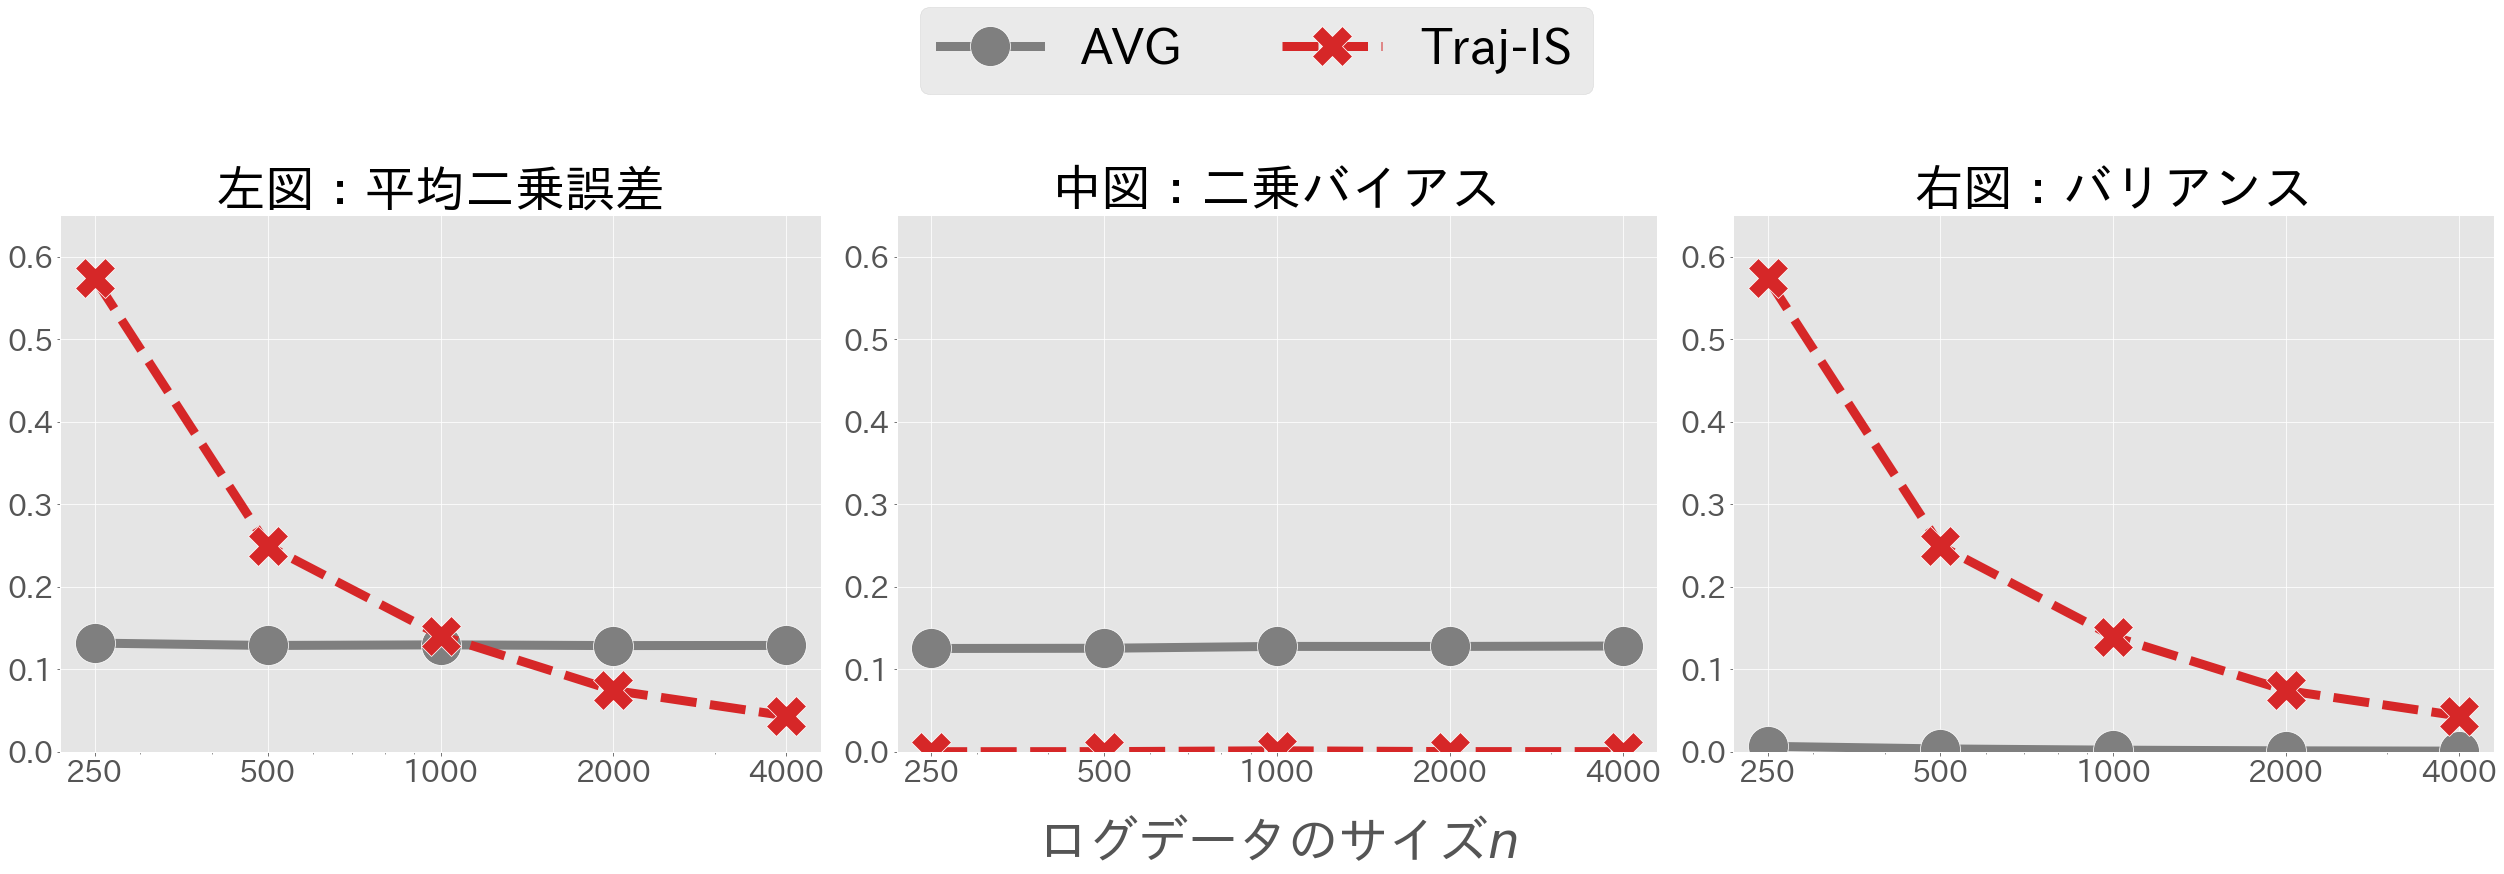

In [27]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red"],
        data=result_df_data.query("est == 'avg' or est == 'tis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.65)
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["AVG", "Traj-IS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=5, loc="center")


## 図4.5

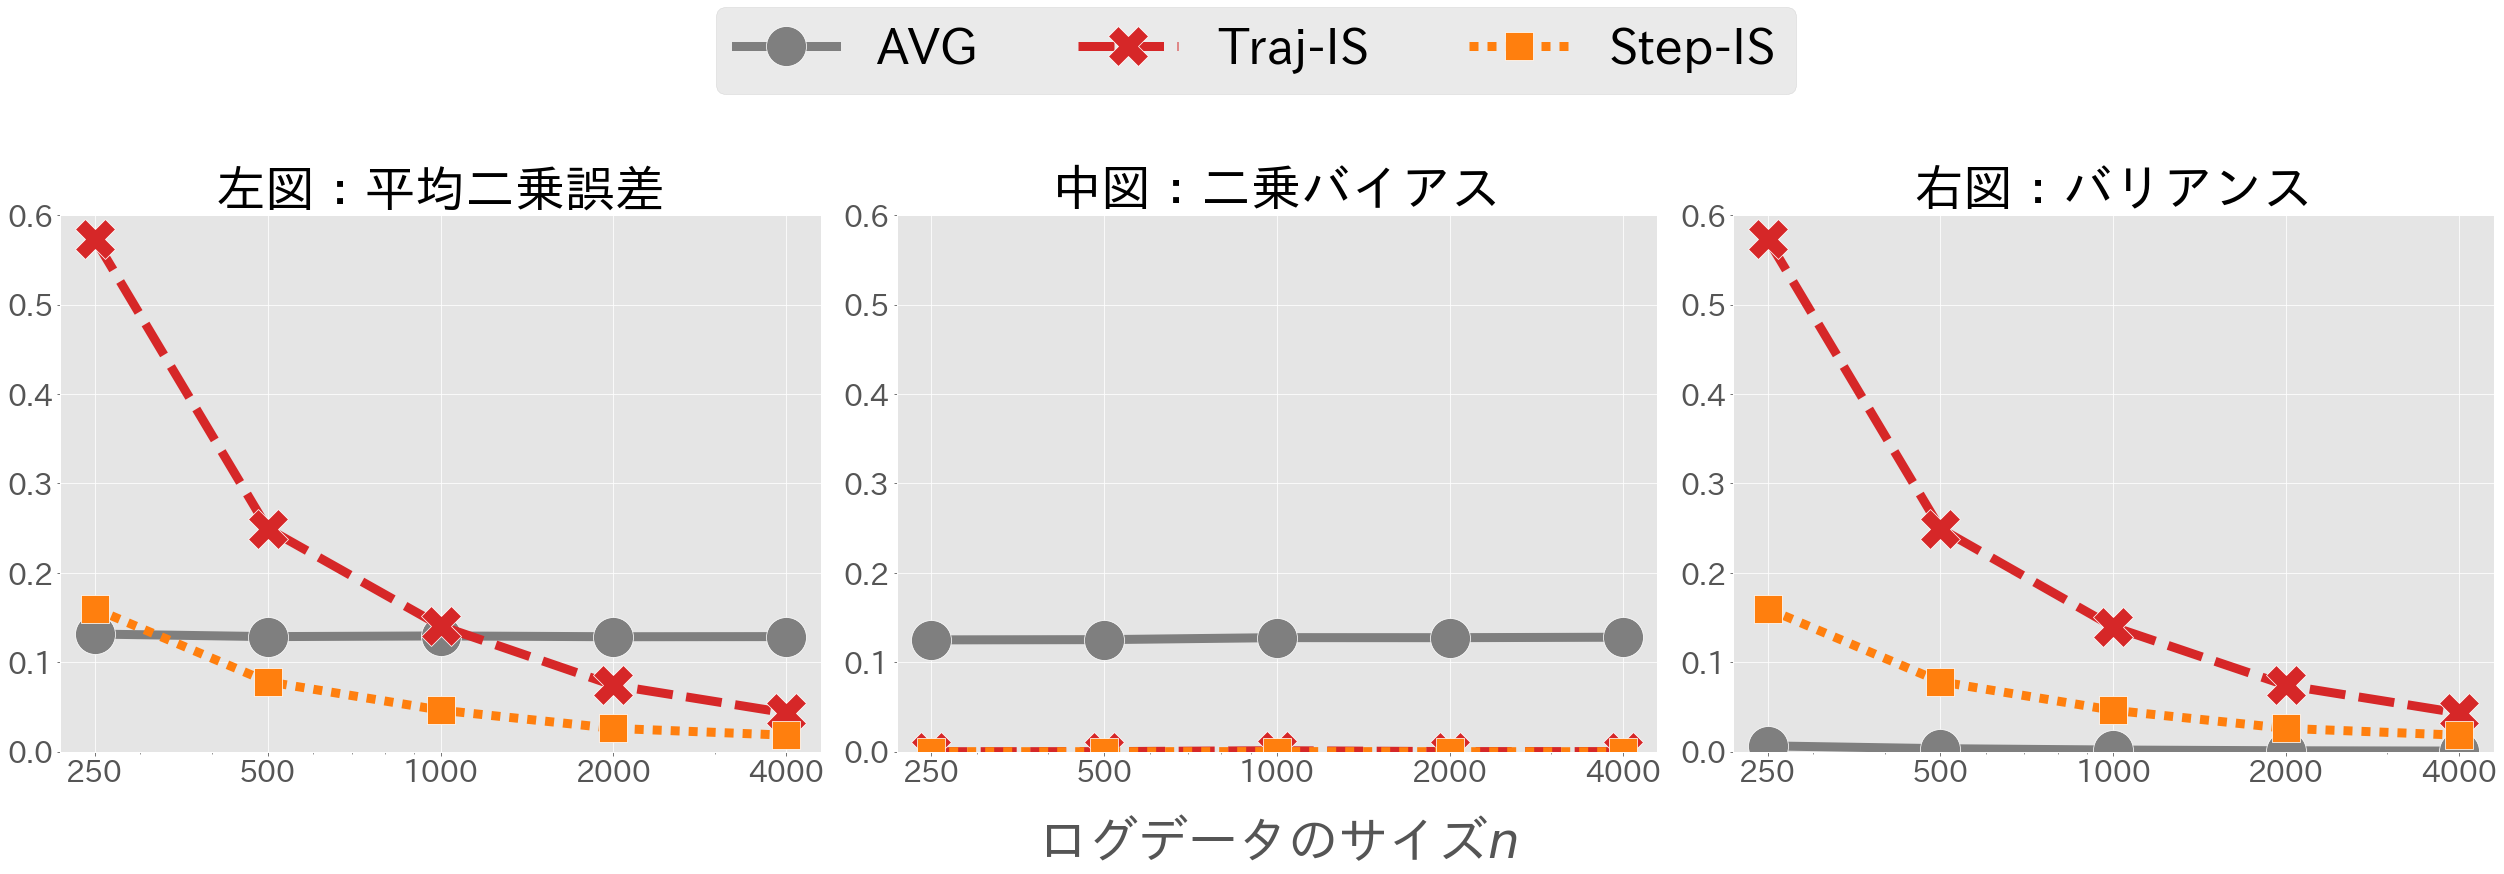

In [26]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red", "tab:orange"],
        data=result_df_data.query("est == 'avg' or est == 'tis' or est == 'sis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.6)
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["AVG", "Traj-IS", "Step-IS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=5, loc="center")


## 図4.7

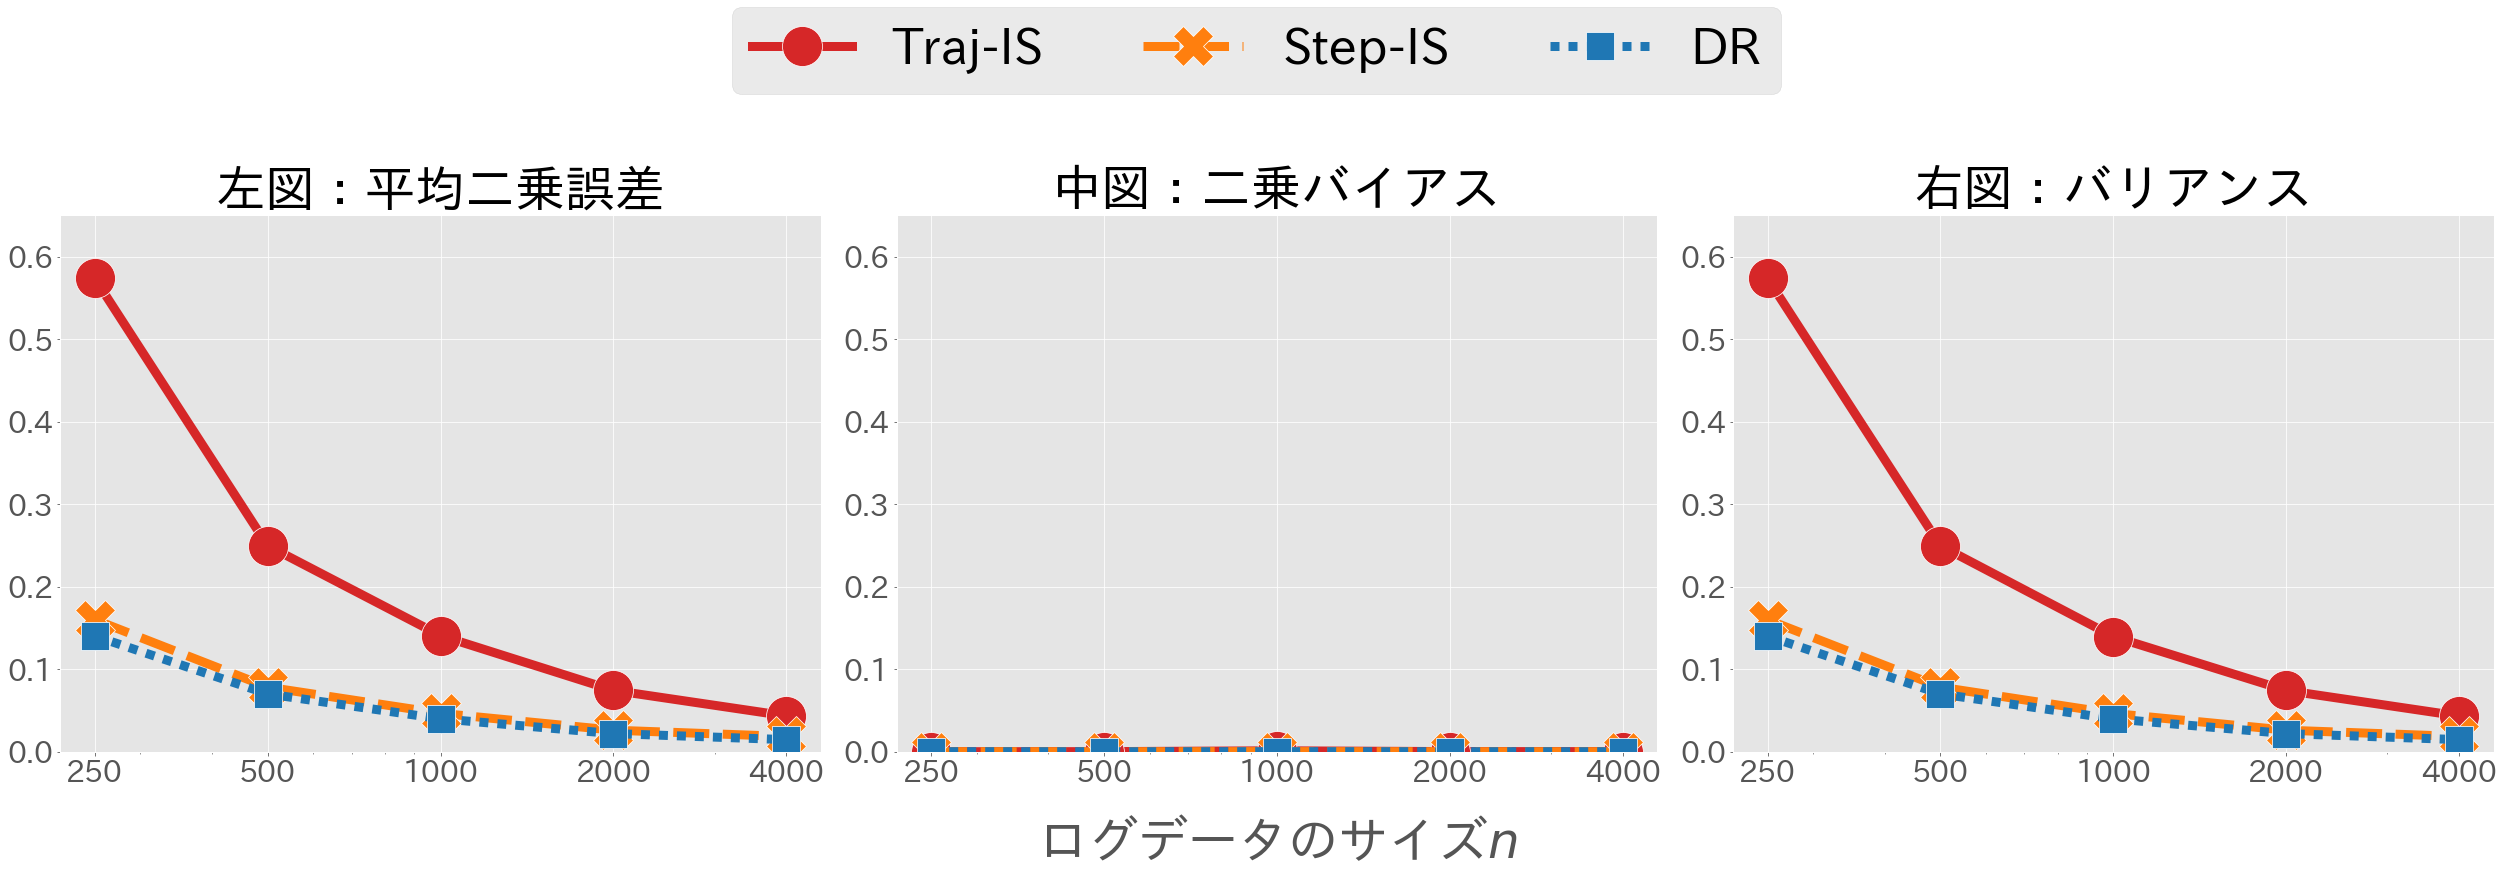

In [25]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange", "tab:blue"],
        data=result_df_data.query("est == 'tis' or est == 'sis' or est == 'dr'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.65)
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["Traj-IS", "Step-IS", "DR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=5, loc="center")

## 図4.9

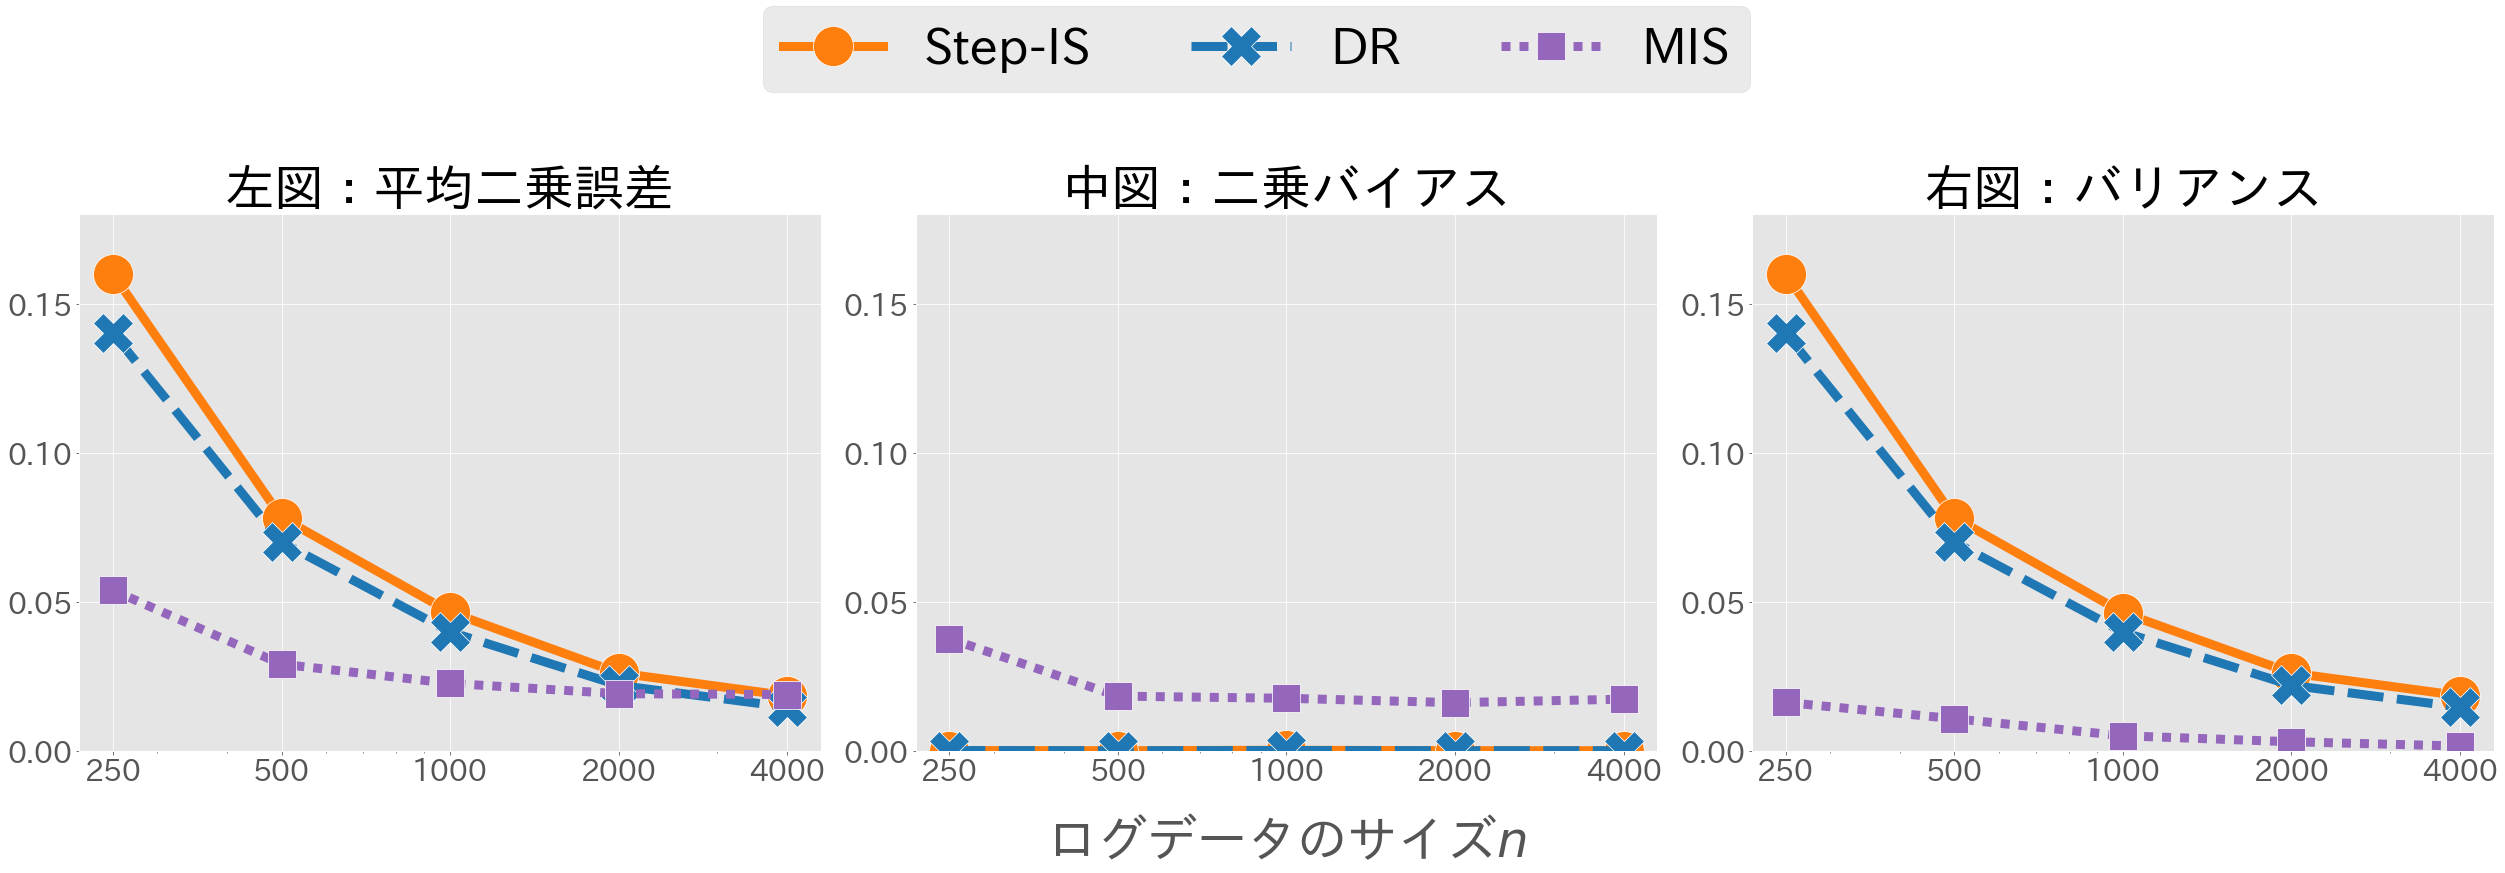

In [7]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:orange", "tab:blue", "tab:purple"],
        data=result_df_data.query("est == 'sis' or est == 'dr' or est == 'mis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.18)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.05, 0.1, 0.15])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["Step-IS", "DR", "MIS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=5, loc="center")


### 軌跡の長さ$H$を変化させたときの各種推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [8]:
## シミュレーション設定
num_runs = 500 # シミュレーションの繰り返し回数
dim_state = 5 # 状態sの次元
num_states = 50 # 状態数, |S|
num_actions = 10 # 行動数, |A|
num_data = 1000 # ログデータのサイズ
beta = -1 # データ収集方策のパラメータ
random_state = 12345
random_ = check_random_state(random_state)
H_list = [4, 6, 8, 10, 12] # 軌跡の長さ

In [9]:
## 期待報酬関数を定義するためのパラメータを抽出
random_ = check_random_state(random_state)
theta = random_.normal(size=(dim_state, num_actions))
M = random_.normal(size=(dim_state, num_actions))
b = random_.normal(size=(1, num_actions))
init_dist = softmax(random_.normal(size=(1, num_states)))[0]
trans_probs = softmax(random_.normal(size=(num_states, num_states, num_actions)) / 2)
result_df_list = []
for H in H_list:
    ## 評価方策の真の性能(policy value)を計算
    test_data, policy_value = calc_true_value(
        dim_state=dim_state, num_states=num_states, num_actions=num_actions, H=H,
        theta=theta, M=M, b=b, init_dist=init_dist, trans_probs=trans_probs,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"H={H}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, dim_state=dim_state, num_states=num_states, num_actions=num_actions, H=H,
            theta=theta, M=M, b=b, init_dist=init_dist, trans_probs=trans_probs, beta=beta, random_state=_,
        )

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_avg(offline_logged_data)
        estimated_policy_values["tis"] = calc_tis(offline_logged_data)
        estimated_policy_values["sis"] = calc_sis(offline_logged_data)
        Q_hat = offline_logged_data["q_s_a"] # ここではQ関数の推定モデルを適当に置く
        estimated_policy_values["dr"] = calc_dr(offline_logged_data, Q_hat)
        estimated_policy_values["mis"] = calc_mis(offline_logged_data, test_data)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "H", H,
        )
    )
result_df_horizon = pd.concat(result_df_list).reset_index(level=0)


H=12...: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


## 図4.3

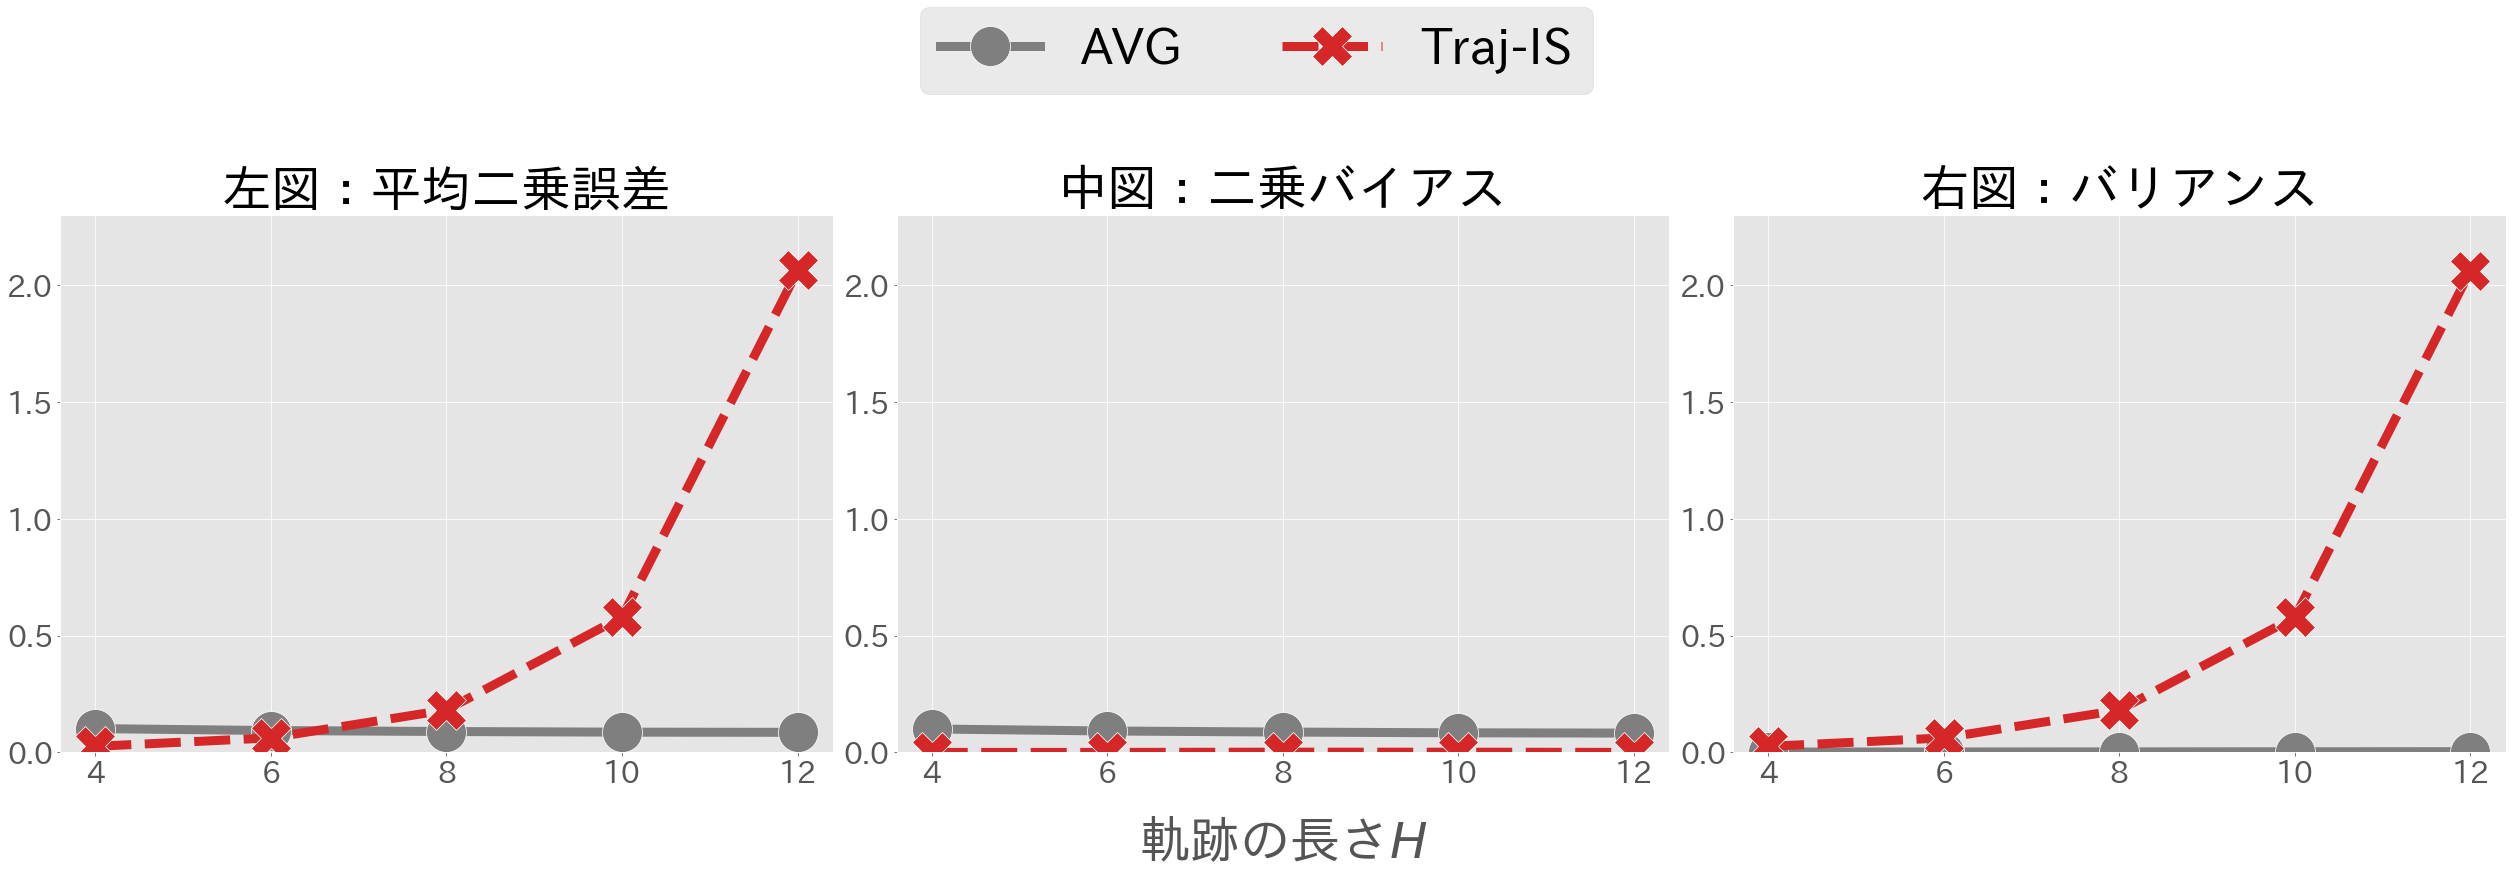

In [24]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="H",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red"],
        data=result_df_horizon.query("est == 'avg' or est == 'tis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 2.3)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"軌跡の長さ$H$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(H_list)
    ax.set_xticklabels(H_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["AVG", "Traj-IS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=5, loc="center")


## 図4.6

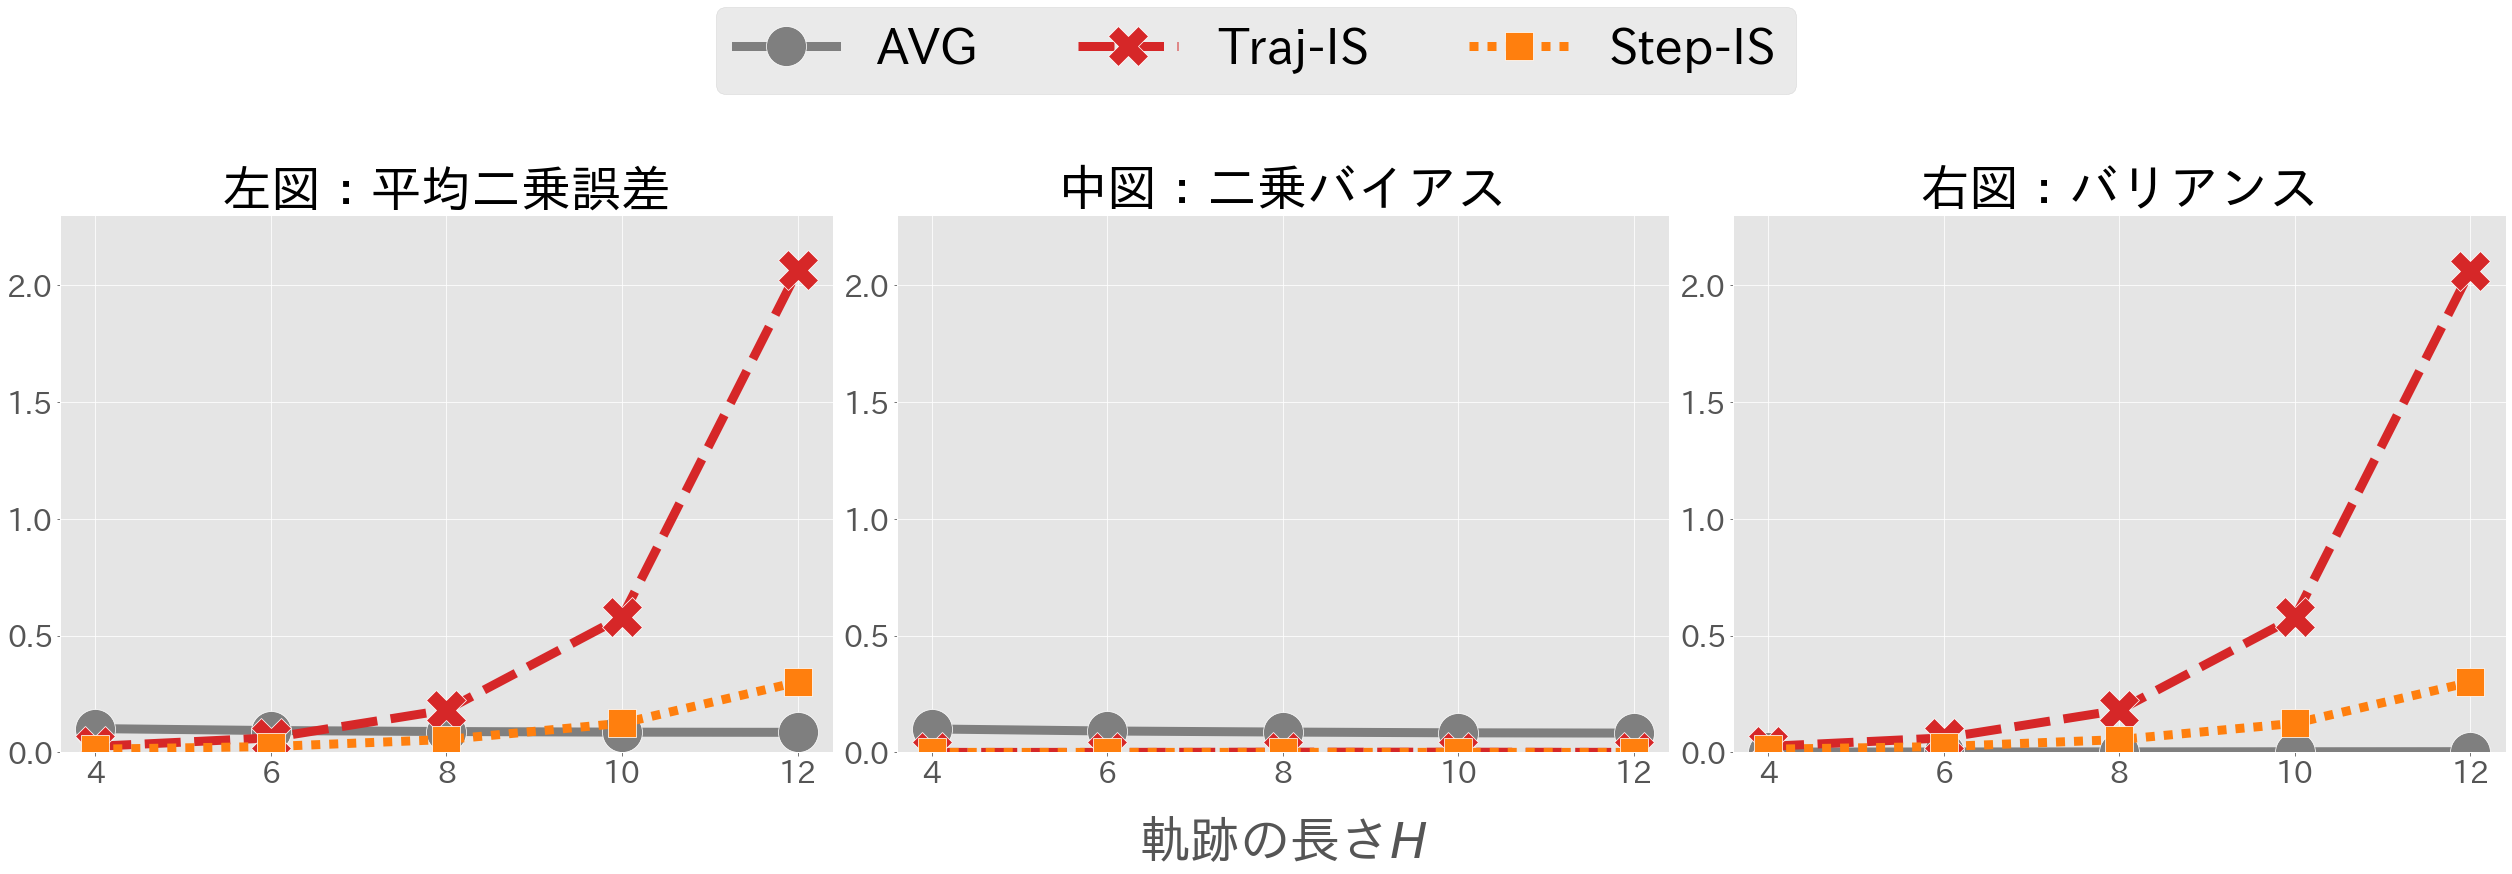

In [23]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="H",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red", "tab:orange"],
        data=result_df_horizon.query("est == 'avg' or est == 'tis' or est == 'sis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 2.3)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"軌跡の長さ$H$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(H_list)
    ax.set_xticklabels(H_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["AVG", "Traj-IS", "Step-IS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=5, loc="center")


## 図4.8

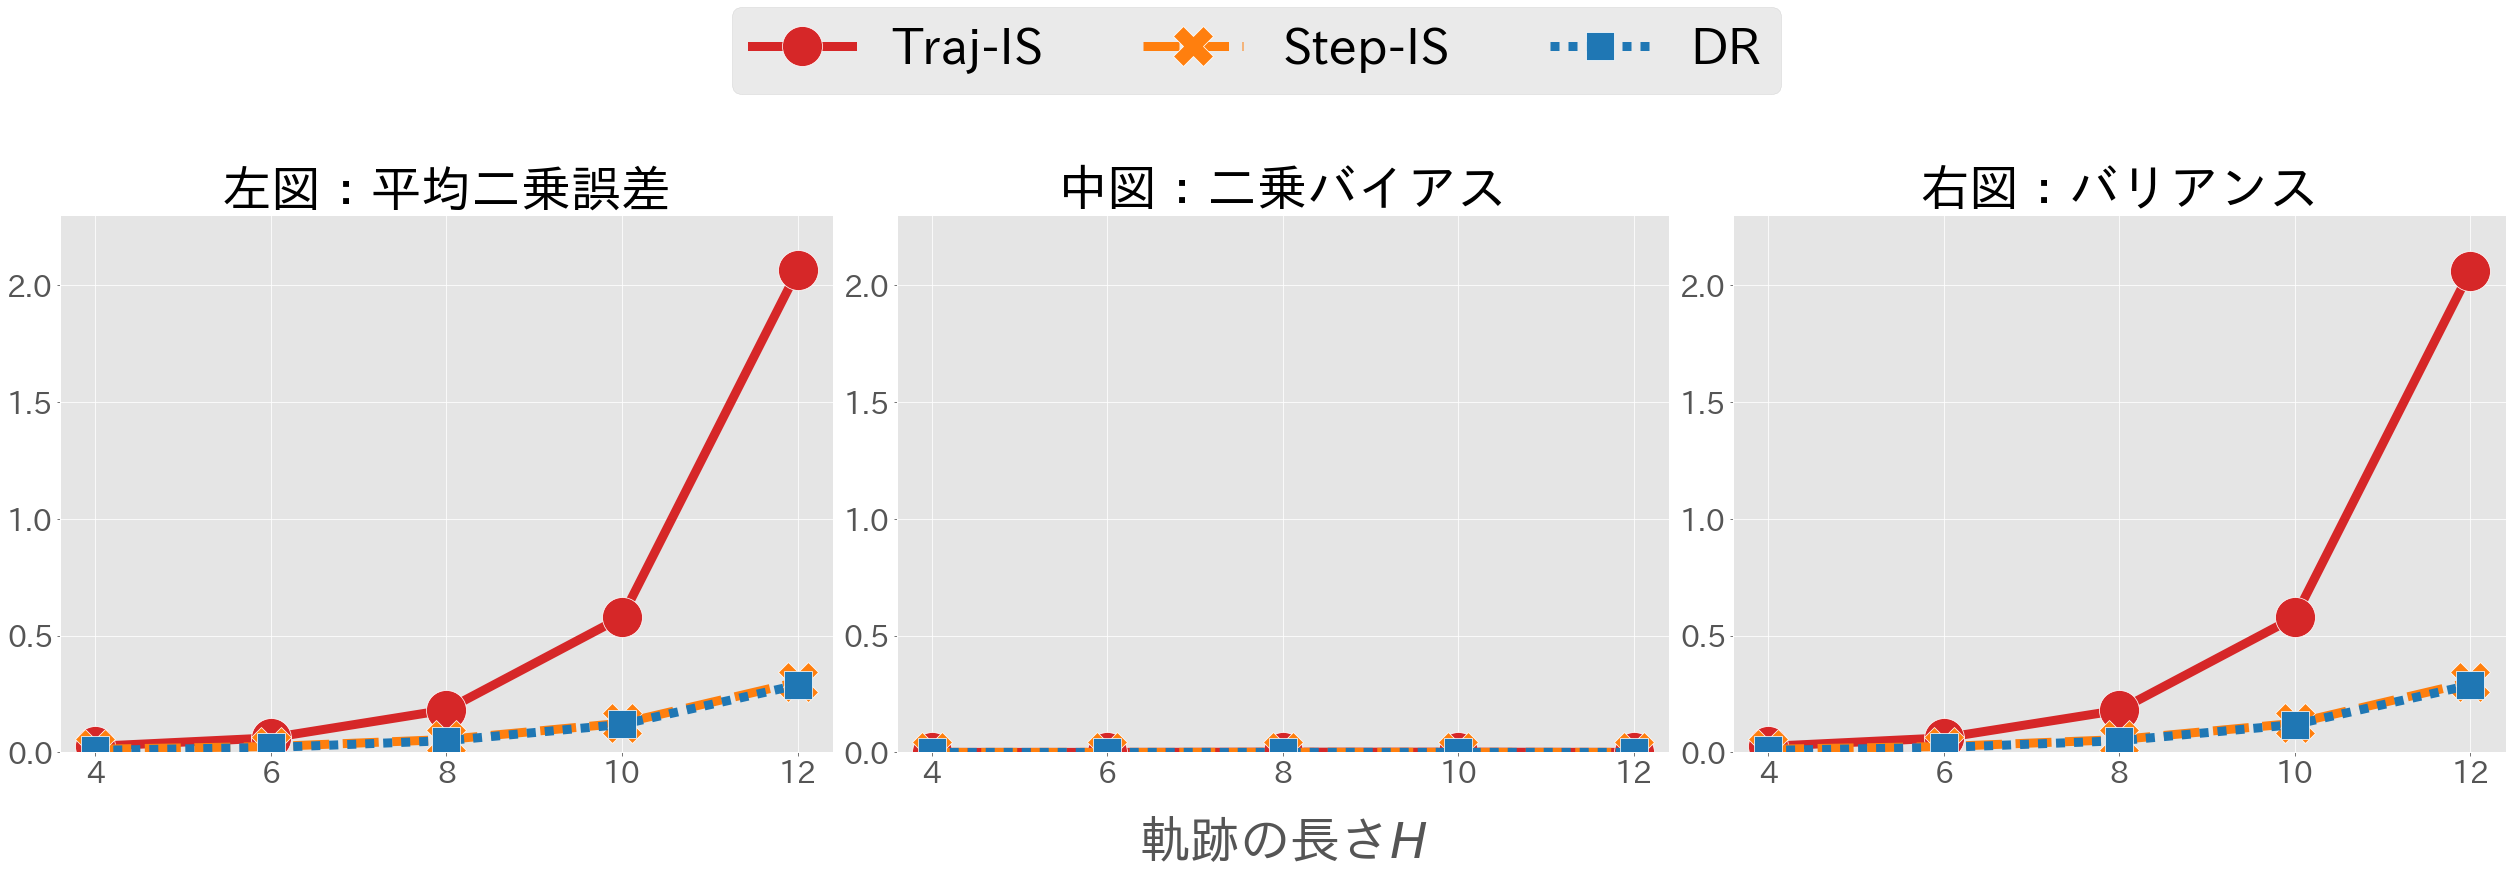

In [22]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="H",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange", "tab:blue"],
        data=result_df_horizon.query("est == 'tis' or est == 'sis' or est == 'dr'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 2.3)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"軌跡の長さ$H$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(H_list)
    ax.set_xticklabels(H_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["Traj-IS", "Step-IS", "DR"], fontsize=50, bbox_to_anchor=(0.5, 1.15),ncol=5, loc="center")


## 図4.10

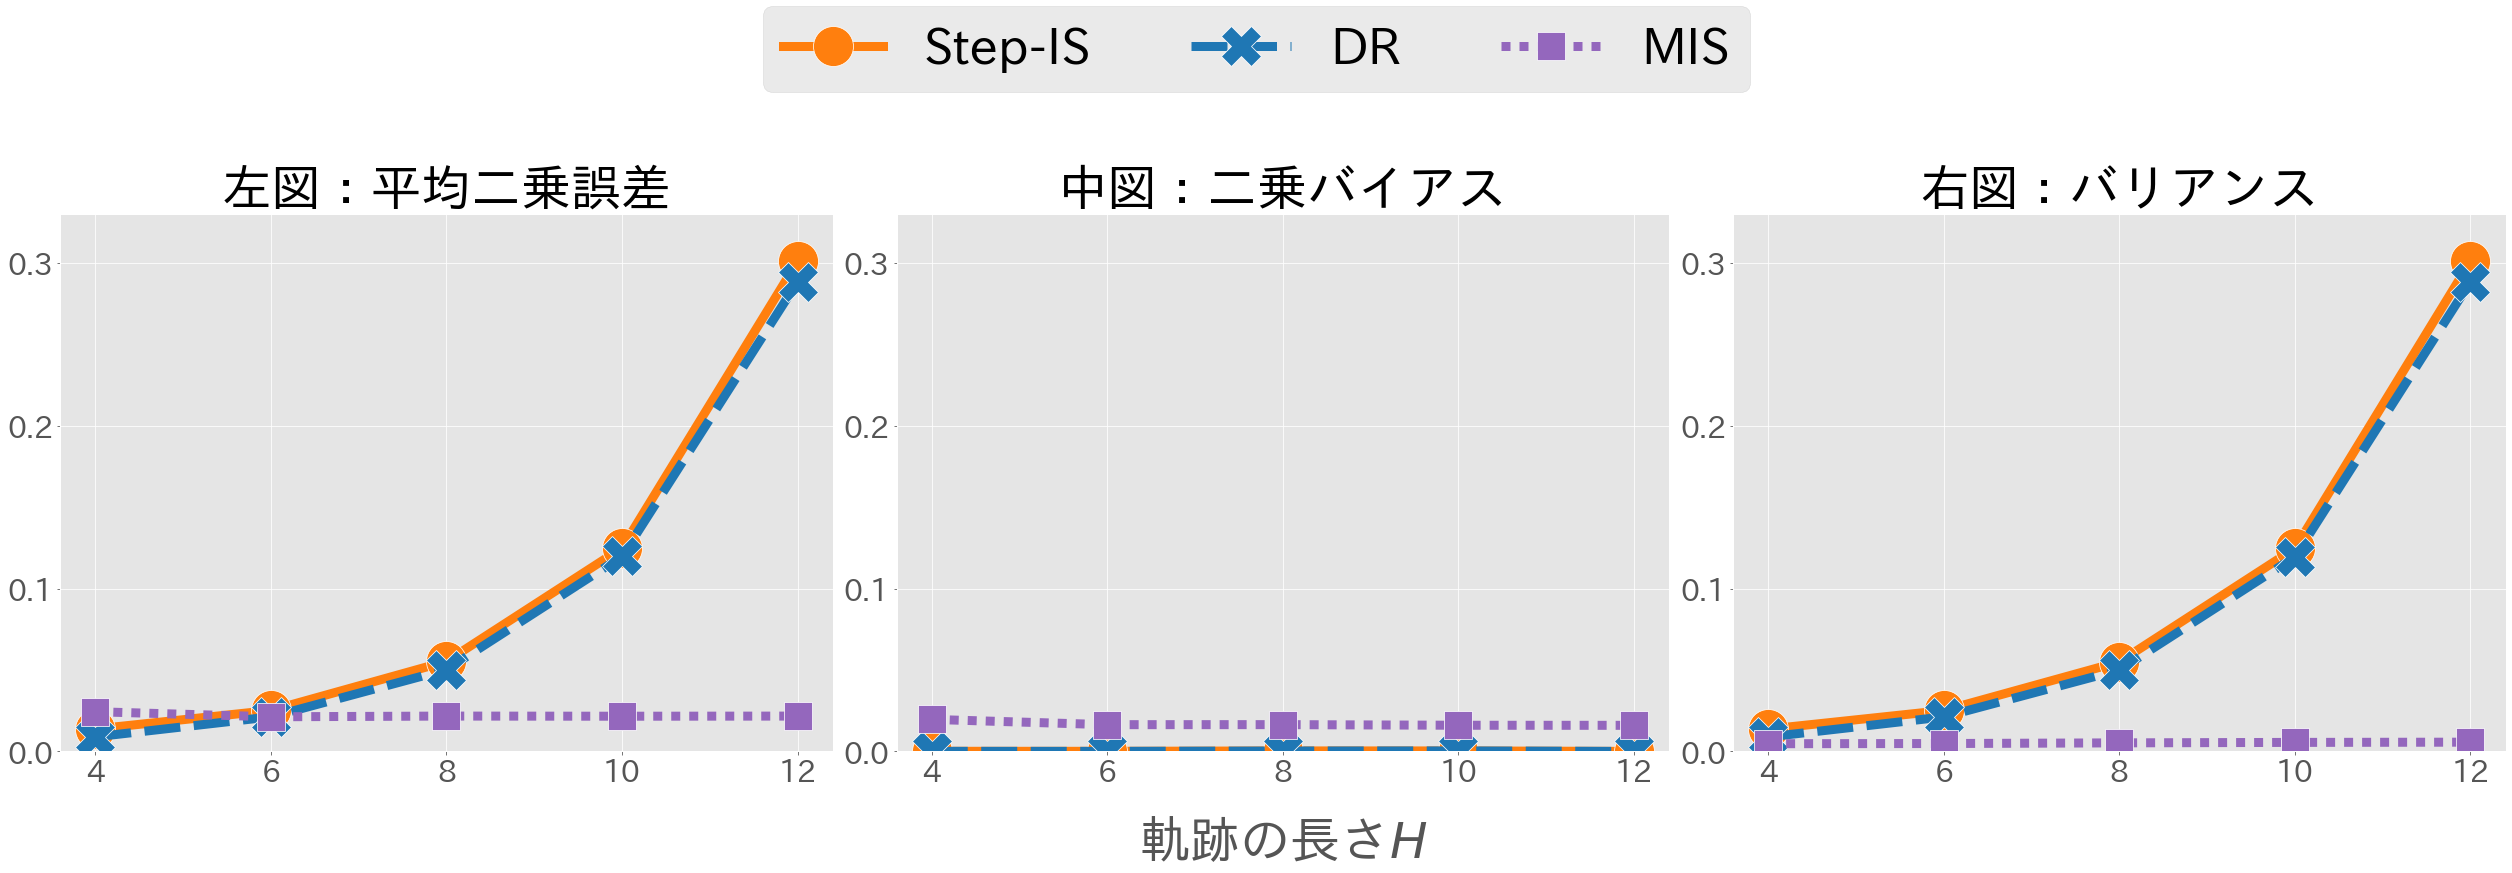

In [19]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="H",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:orange", "tab:blue", "tab:purple"],
        data=result_df_horizon.query("est == 'sis' or est == 'dr' or est == 'mis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.33)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.1, 0.2, 0.3])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"軌跡の長さ$H$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(H_list)
    ax.set_xticklabels(H_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["Step-IS", "DR", "MIS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=5, loc="center")


### 状態数$|S|$を変化させたときの各種推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [14]:
## シミュレーション設定
num_runs = 500 # シミュレーションの繰り返し回数
dim_state = 5 # 状態sの次元
num_actions = 10 # 行動数, |A|
H = 6 # 軌跡の長さ
num_data = 1000 # ログデータのサイズ
beta = -1 # データ収集方策のパラメータ
random_state = 12345
random_ = check_random_state(random_state)
num_states_list = [10, 50, 100, 200, 500] # 状態数, |S|

In [15]:
## 期待報酬関数を定義するためのパラメータを抽出
random_ = check_random_state(random_state)
theta = random_.normal(size=(dim_state, num_actions))
M = random_.normal(size=(dim_state, num_actions))
b = random_.normal(size=(1, num_actions))
result_df_list = []
for num_states in num_states_list:
    init_dist = softmax(random_.normal(size=(1, num_states)))[0]
    trans_probs = softmax(random_.normal(size=(num_states, num_states, num_actions)) / 2)
    ## 評価方策の真の性能(policy value)を計算
    test_data, policy_value = calc_true_value(
        dim_state=dim_state, num_states=num_states, num_actions=num_actions, H=H,
        theta=theta, M=M, b=b, init_dist=init_dist, trans_probs=trans_probs,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_states={num_states}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, dim_state=dim_state, num_states=num_states, num_actions=num_actions, H=H,
            theta=theta, M=M, b=b, init_dist=init_dist, trans_probs=trans_probs, beta=beta, random_state=_,
        )

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_avg(offline_logged_data)
        estimated_policy_values["tis"] = calc_tis(offline_logged_data)
        estimated_policy_values["sis"] = calc_sis(offline_logged_data)
        Q_hat = offline_logged_data["q_s_a"] # ここではQ関数の推定モデルを適当に置く
        estimated_policy_values["dr"] = calc_dr(offline_logged_data, Q_hat)
        estimated_policy_values["mis"] = calc_mis(offline_logged_data, test_data)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_states", num_states,
        )
    )
result_df_num_states = pd.concat(result_df_list).reset_index(level=0)


num_states=500...: 100%|██████████| 500/500 [29:00<00:00,  3.48s/it]


## 図4.11

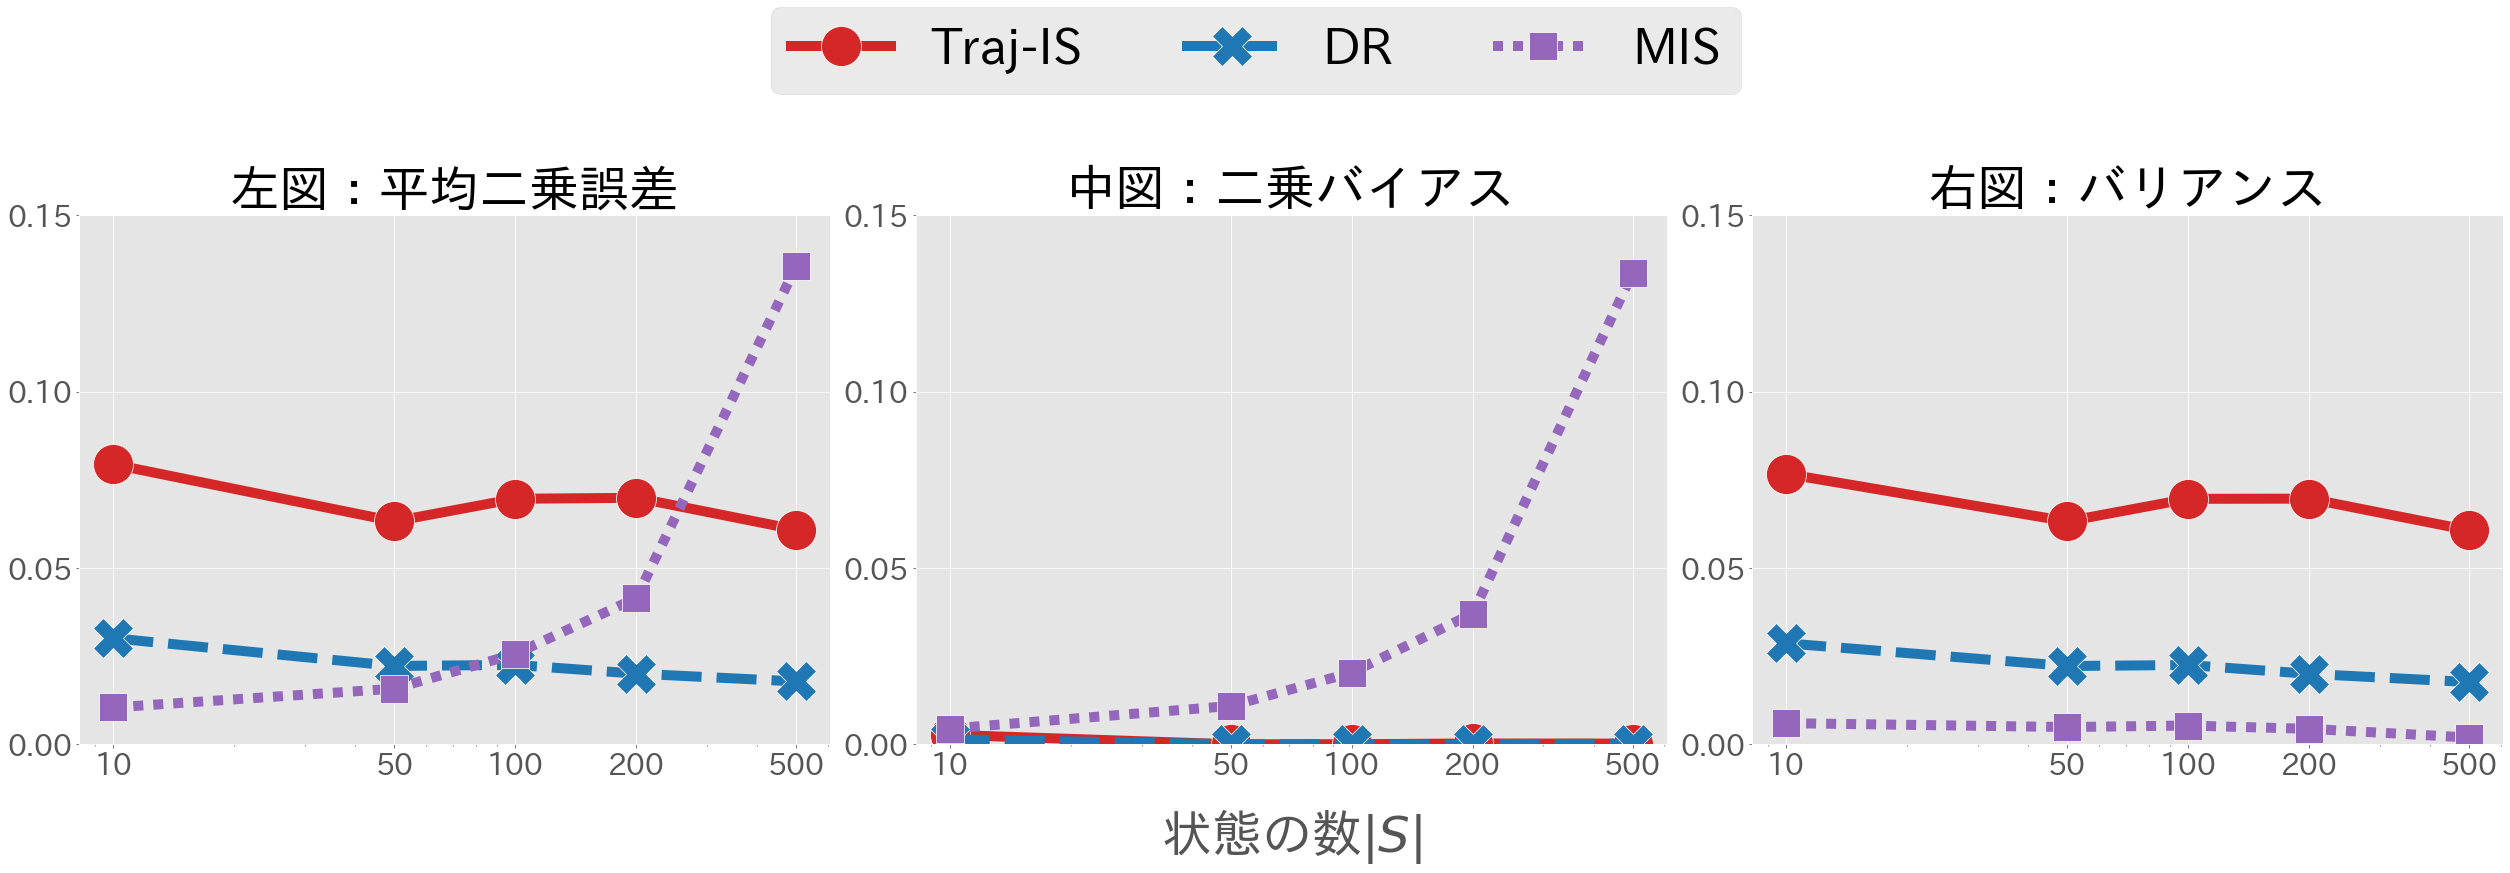

In [16]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=10,
        legend=False,
        style="est",
        x="num_states",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:blue", "tab:purple"],
        data=result_df_num_states.query("est != 'avg' and est != 'sis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.15)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.05, 0.1, 0.15])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"状態の数$|S|$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_states_list)
    ax.set_xticklabels(num_states_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["Traj-IS", "DR", "MIS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=5, loc="center")
